In [1]:
from imblearn.over_sampling import SMOTE
from torchvision import datasets, transforms, models
import os
import pandas as pd
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

# Reading data

In [2]:
path = 'data/train'

In [3]:
def get_data(fulldir):
    classes = os.listdir(fulldir)
    classes.remove('.DS_Store')
    classes.sort()
    class_to_idx = dict(zip(classes, range(len(classes)))) 
    idx_to_class = {v:k for k,v in class_to_idx.items()}
    resizer =  transforms.Resize((324,324))
    convert_tensor = transforms.ToTensor()
    X = []
    y = []
    for i, label in idx_to_class.items():
        path = fulldir+"/"+label
        for file in tqdm(os.listdir(path)):
            X.append(torch.unsqueeze(convert_tensor(resizer(Image.open(path+'/'+file).convert('RGB'))),0))
            y.append(i)
    
    return torch.cat(X,dim=0),y, class_to_idx, idx_to_class
X,y, class_to_idx, idx_to_class = get_data(path)

100%|██████████| 385/385 [00:06<00:00, 62.81it/s]


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42,stratify=y)

In [5]:
def smote_balance(X_train,y_train):
    X_resampled, y_resampled = SMOTE(n_jobs=-1).fit_resample(X_train.reshape(len(X_train),-1), y_train)
    return torch.from_numpy(X_resampled.reshape((len(X_resampled),3,324,324))), y_resampled

In [6]:
X_resampled, y_resampled = smote_balance(X_train,y_train)

/Users/qiwenzhang/opt/anaconda3/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [7]:
np.unique(np.array(y), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]))

In [8]:
np.unique(np.array(y_resampled), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523]))

In [9]:
class PlantDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        item = self.X[idx]
        if self.transform:
            item = self.transform(item)
        return item, self.y[idx]

In [759]:
train_dataset = PlantDataset(X_resampled,y_resampled,train_transform)
val_dataset = PlantDataset(X_val,y_val,val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


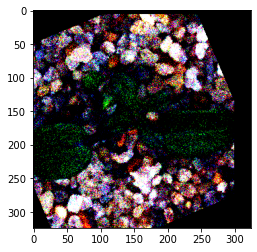

In [821]:
plt.imshow(train_dataset[3700][0].T)

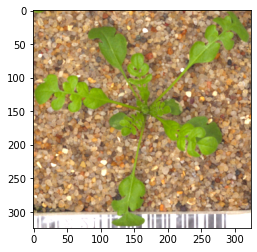

In [964]:
brightness = transforms.ColorJitter(brightness=(2,2))
plt.imshow(brightness(X[3700]).T)

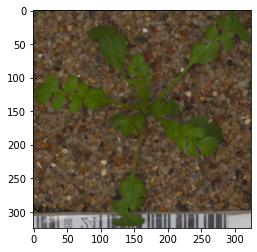

In [955]:
plt.imshow(X[3700].T)

# Transformation
    Scaling
    Cropping
    Flipping
    Rotation
    Translation
    Adding Noise
    Changing lighting conditions
    Advanced techniques like GAN

In [177]:
noiser(totensor(train_dataset[0][0])).size()

torch.Size([324, 3, 324])

In [181]:
totensor(train_dataset[0][0]).size()

torch.Size([324, 3, 324])

In [14]:
noiser = RandomAddGaussianNoise()
noiser(train_dataset[0][0]).shape

torch.Size([3, 324, 324])

tensor([0.0965, 0.1009, 0.1173])

In [572]:
X_val.std([0,2,3])

tensor([0.1065, 0.1122, 0.1302])

In [574]:
mean = X_resampled.mean([0,2,3])
std = X_resampled.std([0,2,3])

In [575]:
mean

tensor([0.3272, 0.2874, 0.2038])

In [576]:
std

tensor([0.0965, 0.1009, 0.1173])

In [718]:
class RandomAddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05,prob=0.5):
        self.std = std
        self.mean = mean
        self.prob = prob
        
    def __call__(self, tensor):
        if np.random.choice(a=[0,1], p=[1-self.prob,self.prob]):
            return tensor + torch.randn(tensor.shape) * self.std + self.mean
        else:
            return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [965]:
train_transform = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomAddGaussianNoise(),
    transforms.ColorJitter(brightness=(0.8,2)),
    transforms.Normalize(mean=[0.3272, 0.2874, 0.2038], std=[0.0965, 0.1009, 0.1173])
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.3272, 0.2874, 0.2038], std=[0.0965, 0.1009, 0.1173])
])

In [967]:
train_loader = DataLoader(train_dataset, batch_size = 4,shuffle=True, drop_last=True )
val_loader = DataLoader(val_dataset, batch_size = 4, drop_last=True )

In [968]:
img, label = next(iter(train_loader))

torch.Size([4, 3, 324, 324])